##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [2]:
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
from lucid.misc.gradient_override import gradient_override_map
import lucid.scratch.web.svelte as lucid_svelte

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tensorpack as tp
import tensorpack.utils.viz as viz

import PIL
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import numpy as np
import sys
from contextlib import contextmanager
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import inception

IMAGE_SIZE = 224

# Attribution Code

In [3]:
# Set up the new inception architecture
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

image = tf.Variable(tf.zeros((224, 224, 3)))

def incep(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v1_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v1(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = incep(image, reuse=False)

restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV1/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, "/home/w266ajh/Documents/model_info/inception_v1.ckpt")

In [4]:
# Here we take in the 1000-dimension vector of potential image labels
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")
labels = [line[line.find(" "):].strip().encode() for line in labels_str.decode().split("\n")]
labels = [label.decode().strip().split()[1].replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [5]:
# model = models.InceptionV1()
# model.load_graphdef()
# print(model)

from contextlib import contextmanager
@contextmanager
def guided_relu():
    """
    Returns:
        A context where the gradient of :meth:`tf.nn.relu` is replaced by
        guided back-propagation, as described in the paper:
        `Striving for Simplicity: The All Convolutional Net
        <https://arxiv.org/abs/1412.6806>`_
    """
    from tensorflow.python.ops import gen_nn_ops   # noqa

    @tf.RegisterGradient("GuidedReLU")
    def GuidedReluGrad(op, grad):
        return tf.where(0. < grad,
                        gen_nn_ops.relu_grad(grad, op.outputs[0]),
                        tf.zeros(grad.get_shape()))

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedReLU'}):
        yield
        
def saliency_map(output, input, name="saliency_map"):
    """
    Produce a saliency map as described in the paper:
    `Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps
    <https://arxiv.org/abs/1312.6034>`_.
    The saliency map is the gradient of the max element in output w.r.t input.

    Returns:
        tf.Tensor: the saliency map. Has the same shape as input.
    """
    max_outp = tf.reduce_max(output, 1)
    saliency_op = tf.gradients(max_outp, input)[:][0]
    return tf.identity(saliency_op, name=name)

# Form our custom model
class Model(tp.ModelDescBase):
    
    def __init__(self):
        self.labels = labels
    
    def inputs(self):
        # should effectively be same as image = tf.Variable(tf.zeros((224, 224, 3)))
        return [tf.placeholder(tf.float32, (IMAGE_SIZE, IMAGE_SIZE, 3), 'image')]

    def build_graph(self, orig_image):
        mean = tf.get_variable('inception_v1/mean_rgb', shape=[3])
        with guided_relu():
            with slim.arg_scope(inception.inception_v1_arg_scope(weight_decay=0.0)):
                image = tf.expand_dims(orig_image - mean, 0)
                logits, _ = inception.inception_v1(
                    image, 1001, is_training=False, reuse=False)
                logits = logits[:,1:] # ignore background class
            #saliency_map(logits, orig_image, name="saliency")
            
model = Model()

In [6]:
def raw_class_spatial_attr(img, layer, label, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    # TODO: Replace model with the new Inception
    #       --> Can we just input the model object form adv_sal? (p/n)
    T = render.import_custom_model(model, t_input, t_input)
    #T = render.import_model(model, t_input, t_input)
    
    # Compute activations
#     from time import sleep
#     for o in T(layer).get_operations():
#         print(o.name, o.outputs)
#         sleep(0.001)
    print("cur_layer" , layer)
    print("nodes:")
    
    tf.global_variables_initializer().run()
#     for n in tf.get_default_graph().as_graph_def().node:
#         print(n.name)
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    score = T("softmax2_pre_activation")[0, labels.index(label)]
    print(score)
    print(T(layer))
    t_grad = tf.gradients([score], [T(layer)])[0]
    print(t_grad)
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return np.sum(acts * grad, -1)[0]

In [7]:
def raw_spatial_spatial_attr(img, layer1, layer2, override=None):
  """Attribution between spatial positions in two different layers."""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts1 = T(layer1).eval()
    acts2 = T(layer2).eval({T(layer1) : acts1})
    
    # Construct gradient tensor
    # Backprop from spatial position (n_x, n_y) in layer2 to layer1.
    n_x, n_y = tf.placeholder("int32", []), tf.placeholder("int32", [])
    layer2_mags = tf.sqrt(tf.reduce_sum(T(layer2)**2, -1))[0]
    score = layer2_mags[n_x, n_y]
    t_grad = tf.gradients([score], [T(layer1)])[0]
    
    # Compute attribution backwards from each positin in layer2
    attrs = []
    for i in range(acts2.shape[1]):
      attrs_ = []
      for j in range(acts2.shape[2]):
        grad = t_grad.eval({n_x : i, n_y : j, T(layer1) : acts1})
        # linear approximation of imapct
        attr = np.sum(acts1 * grad, -1)[0]
        attrs_.append(attr)
      attrs.append(attrs_)
  return np.asarray(attrs)

In [8]:
def orange_blue(a,b,clip=False):
  if clip:
    a,b = np.maximum(a,0), np.maximum(b,0)
  arr = np.stack([a, (a + b)/2., b], -1)
  arr /= 1e-2 + np.abs(arr).max()/1.5
  arr += 0.3
  return arr

# Spatial Attribution Interface

In this section, we build the *interface* for interacting with the different kinds of spatial attribution data that we can compute using the above functions. Feel free to skip over this if you aren't interested in that part. The main reason we're including it is so that you can change the interface if you want to.


In [9]:
%%html_define_svelte SpatialWidget

<div class="figure" style="width: 500px; height: 250px; contain: strict;">
  <div class="outer" on:mouseleave="set({pos2: undefined})">
    <img class="img"  src="{{img}}">
    <img class="attr" src="{{(pos1 == undefined)? hint1 : spritemap1[pos1[1]][pos1[0]]}}">

    <svg class="pointer_container" viewBox="0 0 {{size1}} {{size1}}">
      {{#each xs1 as x}}
      {{#each ys1 as y}}
        <rect x={{x}} y={{y}} width=1 height=1
          class={{(pos2 != undefined && x == pos2[0] && y == pos2[1])? "selected" : ""}}
          on:mouseover="set({pos2: [x,y], pos1: undefined})"></rect>
      {{/each}}
      {{/each}}
    </svg> 

    <div class="label">{{layer1}}</div>
  </div>

  <div class="outer" on:mouseleave="set({pos1: undefined})">
    <img class="img" src="{{img}}">
    <img class="attr" src="{{(pos2 == undefined)? hint2 : spritemap2[pos2[1]][pos2[0]]}}">

    <svg class="pointer_container" viewBox="0 0 {{size2}} {{size2}}">
      {{#each xs2 as x}}
      {{#each ys2 as y}}
        <rect x={{x}} y={{y}} width=1 height=1
          class={{(pos1 != undefined && x == pos1[0] && y == pos1[1])? "selected" : ""}}
          on:mouseover="set({pos1: [x,y], pos2: undefined})"></rect>
      {{/each}}
      {{/each}}
    </svg> 

    <div class="label">{{layer2}}</div>
  </div>
  
</div>


<style>

  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img, .outer svg {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .attr {
    opacity: 0.6;
  }
  .pointer_container {
    z-index: 100;
  }
  .pointer_container rect {
    opacity: 0;
  }
  .pointer_container .selected  {
    opacity: 1;
    fill: none;
    stroke: hsl(24, 100%, 50%);
    stroke-width: 0.1px;
  }
  .label{
    position: absolute;
    left: 0px;
    top: 226px;
    width: 224px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        hint1: "",
        hint2: "",
        spritemap1 : "",
        size1: 1,
        spritemap2 : "",
        size2: 1,
        pos1: undefined,
        pos2: undefined,
        layer1: "",
        layer2: ""
      };
    },
    computed: {
      xs1: (size1) => range(size1),
      ys1: (size1) => range(size1),
      xs2: (size2) => range(size2),
      ys2: (size2) => range(size2)
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_su4ooejv/SpatialWidget_dbeba1cf_a1ad_4d03_bf2a_54103b14df82.html > /tmp/svelte_su4ooejv/SpatialWidget_dbeba1cf_a1ad_4d03_bf2a_54103b14df82.js
b'svelte version 1.64.1\ncompiling ../../../../tmp/svelte_su4ooejv/SpatialWidget_dbeba1cf_a1ad_4d03_bf2a_54103b14df82.html...\n(4:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(5:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(21:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(22:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n'


In [10]:
def image_url_grid(grid):
  return [[_image_url(img) for img in line] for line in grid ]

def spatial_spatial_attr(img, layer1, layer2, hint_label_1=None, hint_label_2=None, override=None):
  
  hint1 = orange_blue(
      raw_class_spatial_attr(img, layer1, hint_label_1, override=override),
      raw_class_spatial_attr(img, layer1, hint_label_2, override=override),
      clip=True
  )
  hint2 = orange_blue(
      raw_class_spatial_attr(img, layer2, hint_label_1, override=override),
      raw_class_spatial_attr(img, layer2, hint_label_2, override=override),
      clip=True
  )

  attrs = raw_spatial_spatial_attr(img, layer1, layer2, override=override)
  attrs = attrs / attrs.max()
  
  lucid_svelte.SpatialWidget({
    "spritemap1": image_url_grid(attrs),
    "spritemap2": image_url_grid(attrs.transpose(2,3,0,1)),
    "size1": attrs.shape[3],
    "layer1": layer1,
    "size2": attrs.shape[0],
    "layer2": layer2,
    "img" : _image_url(img),
    "hint1": _image_url(hint1),
    "hint2": _image_url(hint2)
  })

In [11]:
# Define our custom get_top_five
def get_top_five(path, img):
    # Get predictions
    p = sess.run(probs, feed_dict={image: img})[0]
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    
    # Put results in nice list
    current_results = [path]
    for i in range(5):
        current_results.append('{}: probability: {:.02f}, label: {}'
              .format(i+1, topprobs[i], imagenet_labels[topk[i]]))

    #return(topk, topprobs, [imagenet_labels[i] for i in topk])
    # Legacy requires us to wrap the results in another empty list
    to_return = []
    to_return.append(current_results)
    return(to_return)

# Simple Attribution Example

In [12]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

# import json
# imagenet_json, _ = urlretrieve(
#     'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
# with open(imagenet_json) as f:
#     imagenet_labels = json.load(f)

#spatial_spatial_attr(img, "mixed4d", "mixed5a", hint_label_1="Labrador retriever", hint_label_2="tiger cat")
# sess.run(probs, feed_dict={image: img})

# model_path = "/home/w266ajh/Documents/inception_v1.ckpt"
# predictor = tp.OfflinePredictor(tp.PredictConfig(
#         model=model,
#         session_init=tp.get_model_loader(model_path),
#         input_names=['image'],
#         output_names=['saliency']))
# saliency_images = predictor(img)[0]
# print(type(saliency_images))
spatial_spatial_attr(img, "Mixed_4e", "Mixed_5b", hint_label_1="Labrador retriever", hint_label_2="tiger cat")

#print "\nHover on images to interact! :D\n"

cur_layer Mixed_4e
nodes:
Tensor("strided_slice_1:0", shape=(), dtype=float32)
Tensor("InceptionV1/InceptionV1/Mixed_4e/concat:0", shape=(1, ?, ?, 528), dtype=float32)


ValueError: Cannot convert a partially known TensorShape to a Tensor: (1, ?, ?, 384)

In [12]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

zeros/shape_as_tensor
zeros/Const
zeros
Variable
Variable/Assign
Variable/read
ExpandDims/dim
ExpandDims
Sub/y
Sub
Mul/y
Mul
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal/shape
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal/mean
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal/stddev
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal/mul
InceptionV1/Conv2d_1a_7x7/weights/Initializer/truncated_normal
InceptionV1/Conv2d_1a_7x7/weights
InceptionV1/Conv2d_1a_7x7/weights/Assign
InceptionV1/Conv2d_1a_7x7/weights/read
InceptionV1/InceptionV1/Conv2d_1a_7x7/dilation_rate
InceptionV1/InceptionV1/Conv2d_1a_7x7/Conv2D
InceptionV1/InceptionV1/Conv2d_1a_7x7/BatchNorm/Const
InceptionV1/Conv2d_1a_7x7/BatchNorm/beta/Initializer/zeros
InceptionV1/Conv2d_1a_7x7/BatchNorm/beta
InceptionV1/Conv2d_1a_7x7/BatchNorm/beta/Assign
InceptionV1/Conv2d_1a_7x7/BatchNorm/beta/read



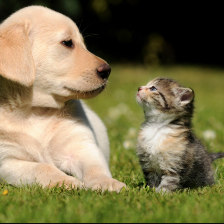

In [26]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

spatial_spatial_attr(img, "mixed4a", "mixed4d", hint_label_1="Labrador retriever", hint_label_2="tiger cat")
